# Notebook to test SetFit performance

Check CUDA

In [1]:
import torch
if torch.cuda.is_available():    
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Load dataset and transform data

In [2]:
import pandas as pd
import numpy as np

dataFrame = pd.read_pickle(r'../data/7587_corrige.pkl')

In [3]:
subset = dataFrame[['jobTitle', 'description', 'label']].copy()

subset.reset_index(drop=True, inplace=True)
subset.replace('', np.nan, inplace=True)
subset.dropna(inplace=True)

subset['text'] = subset['jobTitle'] + ' ' + subset['description']
subset['label'] = np.where((subset["label"] < 3) | (subset["label"].isna()), 0, 1)
subset = subset[['text','label']]
subset

,text,label
2,Stagiaire ingénieur en intelligence artificiel...,1
3,Stagiaire en développement logiciel Développem...,0
4,Stagiaire en développement Web Création et évo...,0
5,Stagiaire en développement Web Portage d’une a...,0
6,Développeur Data / IA Développement d'applicat...,1
...,...,...
11281,Opérateur production Montage de transmission a...,0
11282,Opérateur production Montage de transmission a...,0
11283,Technicien réparation informatique Reparation ...,0
11284,Technicien réparation Reparation & maintenance...,0


Split the dataset in two: training and test set

In [4]:
from datasets import Dataset, disable_progress_bar
disable_progress_bar() # Disable "Map" progress bar in the tests

def split_train_test(dataset, ratio):
    test_set = dataset.sample(frac = ratio, random_state=42)
    train_set = dataset.drop(test_set.index)
    return train_set, test_set

train_set, test_set = split_train_test(subset, 0.2)

# Functions to test different hyper parameters

In [5]:
import json
from datetime import datetime
import os


def save_to_json(object, folder_path):
	# Create folder if it doesn't exist
	if not os.path.exists(folder_path):
		os.makedirs(folder_path)
	# Generate file name
	date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
	file_name = folder_path+'/'+str(date)+".json"

	# Create file and save data
	with open(file_name, 'w') as file:
		json.dump(object, file)

In [6]:
from sentence_transformers.losses import CosineSimilarityLoss, BatchAllTripletLoss
from transformers import PrinterCallback, ProgressCallback
from setfit import Trainer, TrainingArguments, sample_dataset, SetFitModel
import gc
import time
import logging
import warnings

# Disable some logs because there were too many messages during the tests
logging.disable(logging.INFO)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

def get_transformer_model(model_name):
    model = SetFitModel.from_pretrained(model_name)
    gc.collect()
    torch.cuda.empty_cache()
    
    return model.to('cuda')

def init_trainer(model, loss, train_dataset, test_dataset):
    trainer_arguments = TrainingArguments(
        show_progress_bar=False,
        loss=loss,
        batch_size=(8,2),
        num_epochs=(1,10) # Number of epochs to use for contrastive learning (for the transformer and for the classification head)
    )

    trainer = Trainer(
        model=model,
        args=trainer_arguments,
        metric='f1',
        train_dataset=train_dataset,
        eval_dataset=test_dataset
    )
    
    # Disable some logs because there were too many messages during the tests
    trainer.pop_callback(PrinterCallback)
    trainer.pop_callback(ProgressCallback)
    
    return trainer

def setfit_f1_score(train_set, test_set, model_name, loss):   
    if len(train_set) <= 1 or len(test_set) <= 1:
        raise Exception
    
    model = get_transformer_model(model_name)
    trainer = init_trainer(model, loss, train_set, test_set)
    
    start_time = time.time()
    trainer.train()
    run_time = time.time() - start_time
    
    metrics = trainer.evaluate()
    
    del model
    del trainer
    torch.cuda.empty_cache()
    
    return metrics['f1'], run_time

In [7]:
from langdetect import detect

def filter_lang(df, lang):
    indices = []
    for i in range(len(df)):
        try:
            l = detect(df.iloc[i]["text"])
            if l == lang:
                indices.append(i)
        except:""
    
    return df.iloc[indices]

def filter_dataset(data, min_text_length=None, max_text_length=None, lang=None):
    if min_text_length is None:
        if max_text_length is None:
            filtered_data = data
        else:
            filtered_data = data[data['text'].str.split().apply(len) <= max_text_length]
    else:
        if max_text_length is None:
            filtered_data = data[data['text'].str.split().apply(len) >= min_text_length]
        else:
            filtered_data = data[data['text'].str.split().apply(len).between(min_text_length, max_text_length)]
            
    if not (lang is None):
        filtered_data = filter_lang(filtered_data, lang)
           
    return filtered_data

### N-Shots

In [8]:
def n_shot_tests(params, train_set, test_set):
	n_values = params["n_shot"]
	n_iter = params["n_iter"]
	n_max_iter_per_shot = params["n_max_iter_per_shot"]
	model = params["model"]
	loss = params["loss"]
    
	n_values_max = np.max(n_values)

	results = {}
	run_times = {}
	for n_shot in n_values:
		results[n_shot] = []
		run_times[n_shot] = []
	
	progress = 0
	progress_end = n_iter * ((len(n_values)-1)*n_max_iter_per_shot + 1)
 
	# Repeat the tests multiple times because F1-score variations might be due to the examples chosen and not the input length of those examples
	for i in range(n_iter):
		# Use the same subset of the dataset for all of the tests in the following loop
		new_train_set = train_set.sample(frac = 1, random_state=i*47).groupby('label').head(n_values_max)
		new_train_set = Dataset.from_pandas(new_train_set, split="train")
		new_test_set = Dataset.from_pandas(test_set, split="test")

		for n_shot in n_values:
			try:
				n_iter_shot = n_max_iter_per_shot if n_shot < n_values_max else 1
				for i_shot in range(n_iter_shot):
					progress += 1
					print("Step:", progress, "/", progress_end)
     
					train_set_n_shot = sample_dataset(new_train_set, label_column="label", num_samples=n_shot, seed=47*n_shot + 3*i_shot)
					f1_score, run_time = setfit_f1_score(train_set_n_shot, new_test_set, model, loss)
					results[n_shot].append(f1_score)
					run_times[n_shot].append(run_time)
			except Exception as err:
				print(n_shot, "failed", str(err))
	return results, run_times

### Input length

In [9]:
def input_length_tests(params, train_set, test_set):
	n_shot = params["n_shot"]
	len_values = params["input_length_range"]
	n_iter = params["n_iter"]
	model = params["model"]
	loss = params["loss"]
    
	results = {}
	run_times = {}
	new_test_set = Dataset.from_pandas(test_set, split="test")

	for i in range(len(len_values)):
		key = f"[{len_values[i][0]},{len_values[i][1]}]"
		results[key] = []
		run_times[key] = []
		
	results['all'] = []
	run_times['all'] = []

	progress = 0
	progress_end = n_iter * (len(len_values)+1)
 
	# Repeat the tests multiple times because F1-score variations might be due to the examples chosen and not the input length of those examples
	for iter in range(n_iter):
		for i in range(len(len_values)):
			key = f"[{len_values[i][0]},{len_values[i][1]}]"
			try:
				progress += 1
				print("Step:", progress, "/", progress_end)
    
				new_train_set = filter_dataset(train_set, len_values[i][0], len_values[i][1])
				new_train_set = Dataset.from_pandas(new_train_set, split="train")
				new_train_set = sample_dataset(new_train_set, label_column="label", num_samples=n_shot, seed=47*iter)
				f1_score, run_time = setfit_f1_score(new_train_set, new_test_set, model, loss)
				results[key].append(f1_score)
				run_times[key].append(run_time)
			except Exception as err:
				print(key, "failed", str(err))
	
		# Additional test: no length constraint
		try:
			progress += 1
			print("Step:", progress, "/", progress_end)
   
			new_train_set = Dataset.from_pandas(train_set, split="train")
			new_train_set = sample_dataset(new_train_set, label_column="label", num_samples=n_shot, seed=47*iter)
			f1_score, run_time = setfit_f1_score(new_train_set, new_test_set, model, loss)
			results['all'].append(f1_score)
			run_times['all'].append(run_time)
		except Exception as err:
				print("all", "failed", str(err))
	return results, run_times

### Distance

In [10]:
def distance_tests(params, train_set, test_set):
	n_shot = params["n_shot"]
	n_iter = params["n_iter"]
	model = params["model"]
	losses = params["loss"]

	results = {}
	run_times = {}
	for key in losses.keys():
		results[key] = []
		run_times[key] = []

	new_test_set = Dataset.from_pandas(test_set, split="test")
 
	progress = 0
	progress_end = n_iter * (len(losses))

	for i in range(n_iter):
		new_train_set = Dataset.from_pandas(train_set, split="train")
		new_train_set = sample_dataset(new_train_set, label_column="label", num_samples=n_shot, seed=47*i)
		
		for key in losses.keys():
			progress += 1
			print("Step:", progress, "/", progress_end)
   
			try:
				f1_score, run_time = setfit_f1_score(new_train_set, new_test_set, model, losses[key])
				results[key].append(f1_score)
				run_times[key].append(run_time)
			except Exception as err:
				print(key, "failed", str(err))
	return results, run_times

### Language

In [11]:
def language_tests(params, train_set, test_set):
	n_shot = params["n_shot"]
	n_iter = params["n_iter"]
	model = params["model"]
	loss = params["loss"]
	languages = params["lang"]
 
	results = {}
	run_times = {}

	for key in languages:
		results[key] = []
		run_times[key] = []
	results['all'] = []
	run_times['all'] = []
 
	progress = 0
	progress_end = n_iter * (len(languages) + 1)
 
	for i in range(n_iter):
		temp_train_set_panda = {}
		temp_test_set_panda = {}

		for key in languages:
			progress += 1
			print("Step:", progress, "/", progress_end)
   
			temp_train_set_panda[key] = filter_dataset(train_set, lang=key)
			temp_train_set = Dataset.from_pandas(temp_train_set_panda[key], split="train")
			temp_train_set = sample_dataset(temp_train_set, label_column="label", num_samples=n_shot, seed=47*i)
   
			temp_test_set_panda[key] = filter_dataset(test_set, lang=key)
			temp_test_set = Dataset.from_pandas(temp_test_set_panda[key], split="test")
			try:
				f1_score, run_time = setfit_f1_score(temp_train_set, temp_test_set, model, loss)
				results[key].append(f1_score)
				run_times[key].append(run_time)
			except Exception as err:
				print(key, "failed", str(err))
				del temp_train_set_panda[key]
				del temp_test_set_panda[key]
		
		all_temp_train_set = list(temp_train_set_panda.values())
		all_temp_test_set = list(temp_train_set_panda.values())
  
		if len(all_temp_train_set) == 0 or len(all_temp_test_set) == 0:
			progress += 1
			print("Step:", progress, "/", progress_end, "failed")
			continue

		all_train_set = pd.concat(all_temp_train_set)
		all_train_set = Dataset.from_pandas(all_train_set, split="test")
		all_train_set = sample_dataset(all_train_set, label_column="label", num_samples=n_shot, seed=47*i)
		all_test_set = pd.concat(all_temp_test_set)
		all_test_set = Dataset.from_pandas(all_test_set, split="test")
  
		try:
			progress += 1
			print("Step:", progress, "/", progress_end)
   
			f1_score, run_time = setfit_f1_score(all_train_set, all_test_set, model, loss)
			results['all'].append(f1_score)
			run_times['all'].append(run_time)
		except Exception as err:
			print('all', "failed", str(err))
	return results, run_times

### Sentence transformers

Test SetFit with different ST models

In [12]:
def model_tests(params, train_set, test_set):
	n_shot = params["n_shot"]
	n_iter = params["n_iter"]
	loss = params["loss"]
	models = params["model"]
 
	results = {}
	run_times = {}
	new_test_set = Dataset.from_pandas(test_set, split="test")

	for key in models.keys():
		results[key] = []
		run_times[key] = []

	progress = 0
	progress_end = n_iter * len(models)
 
	for i in range(n_iter):
		# Use the same subset of the dataset for all of the tests in the following loop
		new_train_set = Dataset.from_pandas(train_set, split="train")
		new_train_set = sample_dataset(new_train_set, label_column="label", num_samples=n_shot, seed=47*i)

		for key, full_model_name in models.items():
			progress += 1
			print("Step:", progress, "/", progress_end)
   
			try:
				f1_score, run_time = setfit_f1_score(new_train_set, new_test_set, full_model_name, loss)
				results[key].append(f1_score)
				run_times[key].append(run_time)
			except Exception as err:
				print(key, "failed", str(err))
	return results, run_times

## Run tests

In [13]:
def loss_to_str(loss):
    if loss == CosineSimilarityLoss:
        return "Cosine"
    elif loss == BatchAllTripletLoss:
        return "Triplet"
    else:
        return ""

### N-shots

By default SetFit uses the oversampling strategy. For instance if we have 8 positive and 8 negative examples then we have:

|   | Y | Y | Y | Y | Y | Y | Y | Y | N | N | N | N | N | N | N | N |
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
| Y | + | + | + | + | + | + | + | + | - | - | - | - | - | - | - | - |
| Y |   | + | + | + | + | + | + | + | - | - | - | - | - | - | - | - |
| Y |   |   | + | + | + | + | + | + | - | - | - | - | - | - | - | - |
| Y |   |   |   | + | + | + | + | + | - | - | - | - | - | - | - | - |
| Y |   |   |   |   | + | + | + | + | - | - | - | - | - | - | - | - |
| Y |   |   |   |   |   | + | + | + | - | - | - | - | - | - | - | - |
| Y |   |   |   |   |   |   | + | + | - | - | - | - | - | - | - | - |
| Y |   |   |   |   |   |   |   | + | - | - | - | - | - | - | - | - |
| N |   |   |   |   |   |   |   |   | + | + | + | + | + | + | + | + |
| N |   |   |   |   |   |   |   |   |   | + | + | + | + | + | + | + |
| N |   |   |   |   |   |   |   |   |   |   | + | + | + | + | + | + |
| N |   |   |   |   |   |   |   |   |   |   |   | + | + | + | + | + |
| N |   |   |   |   |   |   |   |   |   |   |   |   | + | + | + | + |
| N |   |   |   |   |   |   |   |   |   |   |   |   |   | + | + | + |
| N |   |   |   |   |   |   |   |   |   |   |   |   |   |   | + | + |
| N |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | + |

- P = 2 * (8 + 7 + 6 + 5 + 4 + 3 + 2 + 1) 	= 72
- N = 8 * 8 = 64 -> + 8 duplications 		= 72
- Total = 72 + 72 = 144

In [14]:
params = {
	"n_shot": [2,5,10,30,100],
	"n_iter": 10,
 	"n_max_iter_per_shot": 10,
	"model": "sentence-transformers/paraphrase-mpnet-base-v2",
	"loss": BatchAllTripletLoss
}

results, run_times = n_shot_tests(params, train_set, test_set)

params["loss"] = loss_to_str(params["loss"])
save_to_json({"results":results, "run_times":run_times, "params": params},  r'../results/setfit/n_shot')

Step: 1 / 410
Step: 2 / 410
Step: 3 / 410
Step: 4 / 410
Step: 5 / 410
Step: 6 / 410
Step: 7 / 410
Step: 8 / 410
Step: 9 / 410
Step: 10 / 410
Step: 11 / 410
Step: 12 / 410
Step: 13 / 410
Step: 14 / 410
Step: 15 / 410
Step: 16 / 410
Step: 17 / 410
Step: 18 / 410
Step: 19 / 410
Step: 20 / 410
Step: 21 / 410
Step: 22 / 410
Step: 23 / 410
Step: 24 / 410
Step: 25 / 410
Step: 26 / 410
Step: 27 / 410
Step: 28 / 410
Step: 29 / 410
Step: 30 / 410
Step: 31 / 410
Step: 32 / 410
Step: 33 / 410
Step: 34 / 410
Step: 35 / 410
Step: 36 / 410
Step: 37 / 410
Step: 38 / 410
Step: 39 / 410
Step: 40 / 410
Step: 41 / 410
Step: 42 / 410
Step: 43 / 410
Step: 44 / 410
Step: 45 / 410
Step: 46 / 410
Step: 47 / 410
Step: 48 / 410
Step: 49 / 410
Step: 50 / 410
Step: 51 / 410
Step: 52 / 410
Step: 53 / 410
Step: 54 / 410
Step: 55 / 410
Step: 56 / 410
Step: 57 / 410
Step: 58 / 410
Step: 59 / 410
Step: 60 / 410
Step: 61 / 410
Step: 62 / 410
Step: 63 / 410
Step: 64 / 410
Step: 65 / 410
Step: 66 / 410
Step: 67 / 410
Step

### Input length

In [15]:
params = {
    "input_length_range": [(0,5),(0,10),(0,100),(6,100),(200,350)],
	"n_shot": 8,
	"n_iter": 10,
	"model": "sentence-transformers/paraphrase-mpnet-base-v2",
	"loss": BatchAllTripletLoss
}

results, run_times = input_length_tests(params, train_set, test_set)

params["loss"] = loss_to_str(params["loss"])
save_to_json({"results":results, "run_times":run_times, "params": params},  r'../results/setfit/input_length')

Step: 1 / 60
Step: 2 / 60
Step: 3 / 60
Step: 4 / 60
Step: 5 / 60
Step: 6 / 60
Step: 7 / 60
Step: 8 / 60
Step: 9 / 60
Step: 10 / 60
Step: 11 / 60
Step: 12 / 60
Step: 13 / 60
Step: 14 / 60
Step: 15 / 60
Step: 16 / 60
Step: 17 / 60
Step: 18 / 60
Step: 19 / 60
Step: 20 / 60
Step: 21 / 60
Step: 22 / 60
Step: 23 / 60
Step: 24 / 60
Step: 25 / 60
Step: 26 / 60
Step: 27 / 60
Step: 28 / 60
Step: 29 / 60
Step: 30 / 60
Step: 31 / 60
Step: 32 / 60
Step: 33 / 60
Step: 34 / 60
Step: 35 / 60
Step: 36 / 60
Step: 37 / 60
Step: 38 / 60
Step: 39 / 60
Step: 40 / 60
Step: 41 / 60
Step: 42 / 60
Step: 43 / 60
Step: 44 / 60
Step: 45 / 60
Step: 46 / 60
Step: 47 / 60
Step: 48 / 60
Step: 49 / 60
Step: 50 / 60
Step: 51 / 60
Step: 52 / 60
Step: 53 / 60
Step: 54 / 60
Step: 55 / 60
Step: 56 / 60
Step: 57 / 60
Step: 58 / 60
Step: 59 / 60
Step: 60 / 60


### Distance

In [16]:
params = {
	"n_shot": 8,
	"n_iter": 10,
	"model": "sentence-transformers/paraphrase-mpnet-base-v2",
	"loss": {"Cosine":CosineSimilarityLoss, "Triplet":BatchAllTripletLoss}
}

results, run_times = distance_tests(params, train_set, test_set)

for key in params["loss"].keys():
    params["loss"][key] = loss_to_str(params["loss"][key])
save_to_json({"results":results, "run_times":run_times, "params": params},  r'../results/setfit/distance')

Step: 1 / 20
Step: 2 / 20
Step: 3 / 20
Step: 4 / 20
Step: 5 / 20
Step: 6 / 20
Step: 7 / 20
Step: 8 / 20
Step: 9 / 20
Step: 10 / 20
Step: 11 / 20
Step: 12 / 20
Step: 13 / 20
Step: 14 / 20
Step: 15 / 20
Step: 16 / 20
Step: 17 / 20
Step: 18 / 20
Step: 19 / 20
Step: 20 / 20


### Language

In [17]:
params = {
	"n_shot": 8,
	"lang": ['fr','en'],
	"n_iter": 10,
	"model": "sentence-transformers/paraphrase-mpnet-base-v2",
	"loss": BatchAllTripletLoss
}

results, run_times = language_tests(params, train_set, test_set)

params["loss"] = loss_to_str(params["loss"])
save_to_json({"results":results, "run_times":run_times, "params": params},  r'../results/setfit/language')

Step: 1 / 30
Step: 2 / 30
Step: 3 / 30
Step: 4 / 30
Step: 5 / 30
Step: 6 / 30
Step: 7 / 30
Step: 8 / 30
Step: 9 / 30
Step: 10 / 30
Step: 11 / 30
Step: 12 / 30
Step: 13 / 30
Step: 14 / 30
Step: 15 / 30
Step: 16 / 30
Step: 17 / 30
Step: 18 / 30
Step: 19 / 30
Step: 20 / 30
Step: 21 / 30
Step: 22 / 30
Step: 23 / 30
Step: 24 / 30
Step: 25 / 30
Step: 26 / 30
Step: 27 / 30
Step: 28 / 30
Step: 29 / 30
Step: 30 / 30


### Sentence transformers

In [18]:

params = {
	"n_shot": 8,
	"n_iter": 10,
	"loss": BatchAllTripletLoss,
	"model": {
		"paraphrase-mpnet-base-v2": "sentence-transformers/paraphrase-mpnet-base-v2",
		"all-MiniLM-L6-v2": "sentence-transformers/all-MiniLM-L6-v2",
		"paraphrase-multilingual-MiniLM-L12-v2": "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
		"paraphrase-multilingual-mpnet-base-v2": "sentence-transformers/paraphrase-multilingual-mpnet-base-v2",
		"multilingual-e5-small": "intfloat/multilingual-e5-small",
		"all-distilroberta-v1": "sentence-transformers/all-distilroberta-v1",
		"msmarco-distilbert-dot-v5": "sentence-transformers/msmarco-distilbert-dot-v5",
		"bge-small-en-v1.5": "BAAI/bge-small-en-v1.5",
		"all-roberta-large-v1": "sentence-transformers/all-roberta-large-v1"
	}
}

results, run_times = model_tests(params, train_set, test_set)

params["loss"] = loss_to_str(params["loss"])
save_to_json({"results":results, "run_times":run_times, "params": params},  r'../results/setfit/model')

Step: 1 / 90
Step: 2 / 90
Step: 3 / 90
Step: 4 / 90
Step: 5 / 90
Step: 6 / 90
Step: 7 / 90
Step: 8 / 90
Step: 9 / 90
Step: 10 / 90
Step: 11 / 90
Step: 12 / 90
Step: 13 / 90
Step: 14 / 90
Step: 15 / 90
Step: 16 / 90
Step: 17 / 90
Step: 18 / 90
Step: 19 / 90
Step: 20 / 90
Step: 21 / 90
Step: 22 / 90
Step: 23 / 90
Step: 24 / 90
Step: 25 / 90
Step: 26 / 90
Step: 27 / 90
Step: 28 / 90
Step: 29 / 90
Step: 30 / 90
Step: 31 / 90
Step: 32 / 90
Step: 33 / 90
Step: 34 / 90
Step: 35 / 90
Step: 36 / 90
Step: 37 / 90
Step: 38 / 90
Step: 39 / 90
Step: 40 / 90
Step: 41 / 90
Step: 42 / 90
Step: 43 / 90
Step: 44 / 90
Step: 45 / 90
Step: 46 / 90
Step: 47 / 90
Step: 48 / 90
Step: 49 / 90
Step: 50 / 90
Step: 51 / 90
Step: 52 / 90
Step: 53 / 90
Step: 54 / 90
Step: 55 / 90
Step: 56 / 90
Step: 57 / 90
Step: 58 / 90
Step: 59 / 90
Step: 60 / 90
Step: 61 / 90
Step: 62 / 90
Step: 63 / 90
Step: 64 / 90
Step: 65 / 90
Step: 66 / 90
Step: 67 / 90
Step: 68 / 90
Step: 69 / 90
Step: 70 / 90
Step: 71 / 90
Step: 72 / 90
S

## Graphs

In [19]:
import matplotlib.pyplot as plt

def load_results_data(filename, folder):
	with open(folder+"/"+filename, 'r') as file:
		data = json.load(file)
 
	return data['results'], data['run_times']

def load_latest_results_data(folder):
	filenames = os.listdir(folder)
	latest = max(filenames, key=lambda x: os.path.getmtime(os.path.join(folder, x)))
	return load_results_data(latest, folder)

def create_scatter_line_plot(data, title, xlabel, ylabel):
	resultsMeans = {}

	for key in data.keys():
		if len(data[key]) > 0:
			resultsMeans[key] = np.mean(data[key])
		else:
			resultsMeans[key] = 0.0

	xMean = list(resultsMeans.keys())
	yMean = list(resultsMeans.values())

	listOfLists = list(data.values())

	xAll = []
	for i in range(len(listOfLists)): # for each key
		for _ in range(len(listOfLists[i])): # for each repetition of the key
			xAll.append(xMean[i])
	yAll = np.concatenate(list(data.values()))
	
	plt.figure(figsize=(8, 6))
	plt.plot(xMean, yMean, marker='', linestyle='-')
	plt.scatter(xAll, yAll)
	
	for i in range(len(xMean)):
		plt.text(xMean[i], yMean[i], f'{yMean[i]:.2f}', ha='center', bbox = dict(facecolor = 'white', alpha =.8))
	
	plt.title(title)
	plt.xlabel(xlabel)
	plt.ylabel(ylabel)
	
	plt.grid(True)
	plt.show()

def create_bar_plot(data, title, xlabel, ylabel, vertical_xticks=False):
	resultsMeans = {}

	for key in data.keys():
		if len(data[key]) > 0:
			resultsMeans[key] = np.mean(data[key])

	xMean = list(resultsMeans.keys())
	yMean = list(resultsMeans.values())
	
	plt.figure(figsize=(11, 6))
	if vertical_xticks:
		plt.xticks(fontsize=15, rotation='vertical')
	else:
		plt.xticks(fontsize=15)
	plt.yticks(fontsize=15)

	for i in range(len(xMean)):
		plt.text(i, yMean[i], f'{yMean[i]:.2f}', ha = 'center', bbox = dict(facecolor = 'white', alpha =.8))
 
	plt.bar(xMean, yMean)

	plt.title(title)
	plt.xlabel(xlabel)
	plt.ylabel(ylabel)

	plt.show()

### Plot graphs

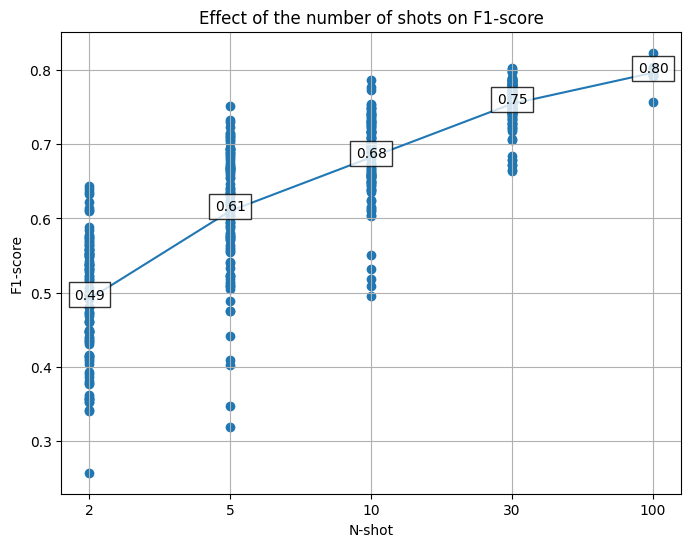

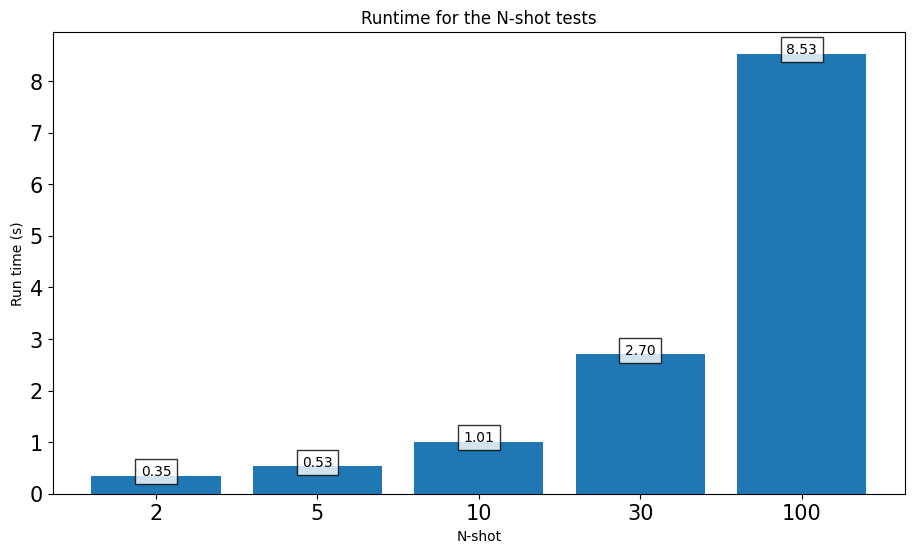

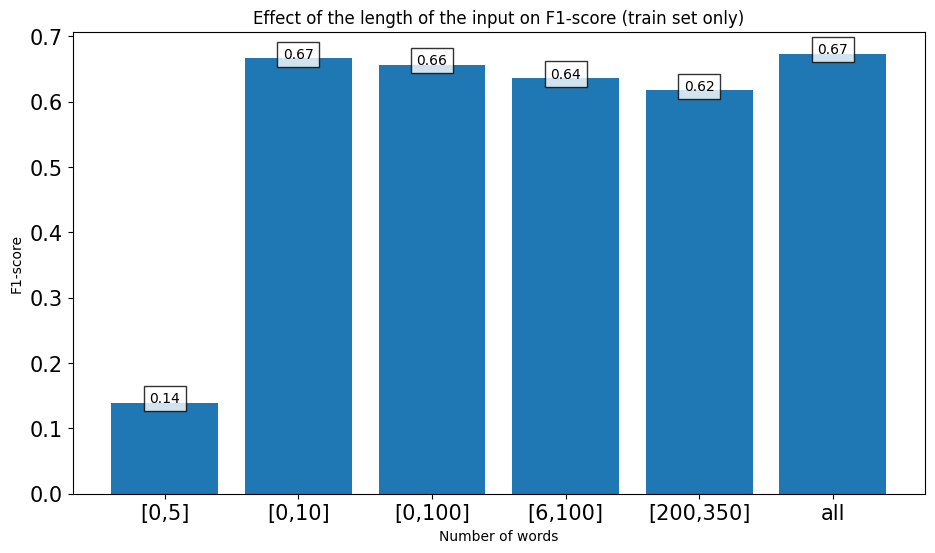

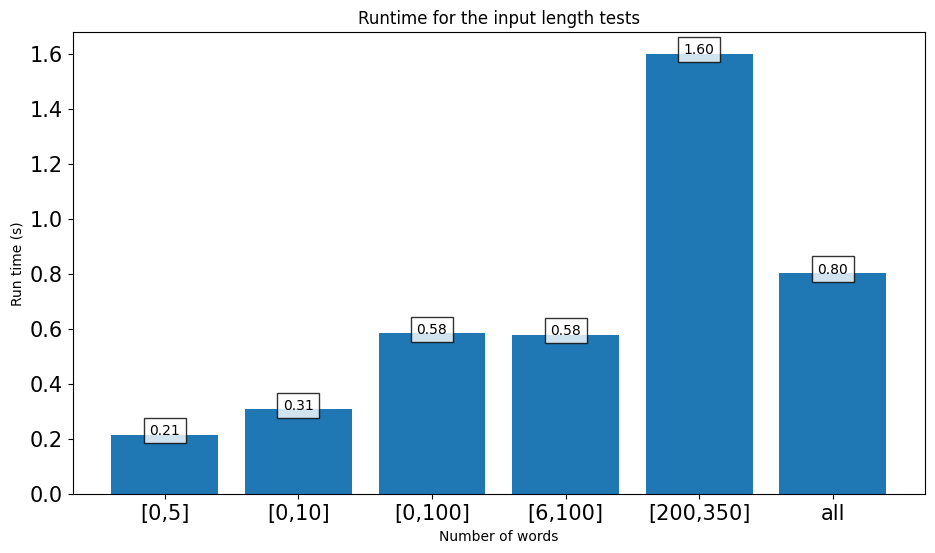

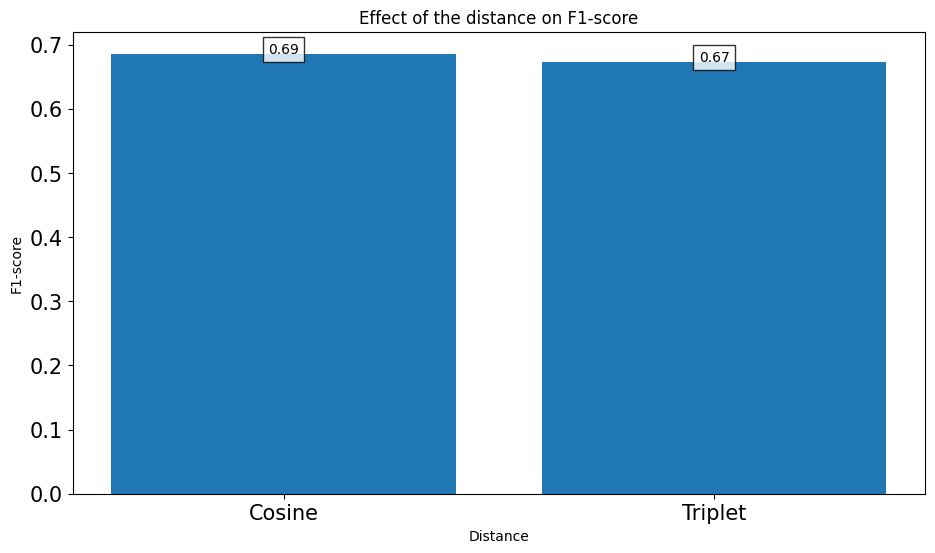

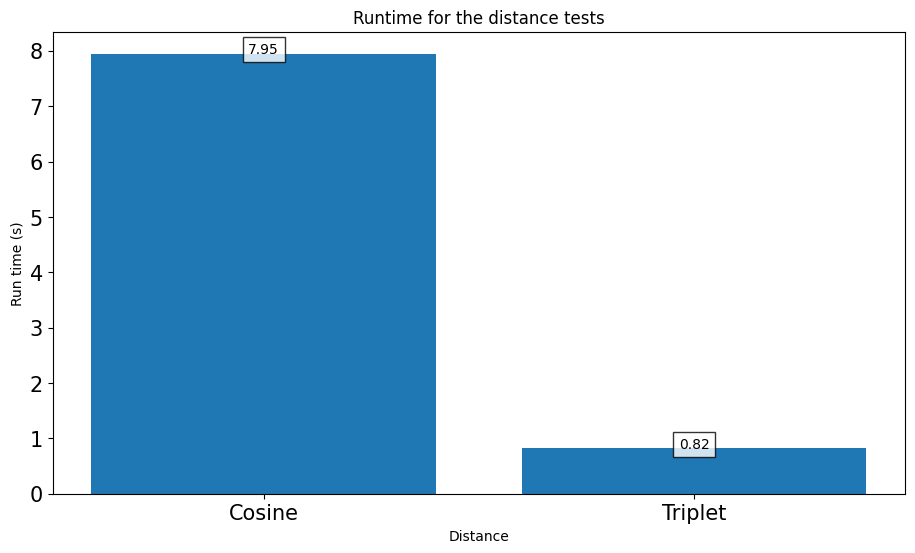

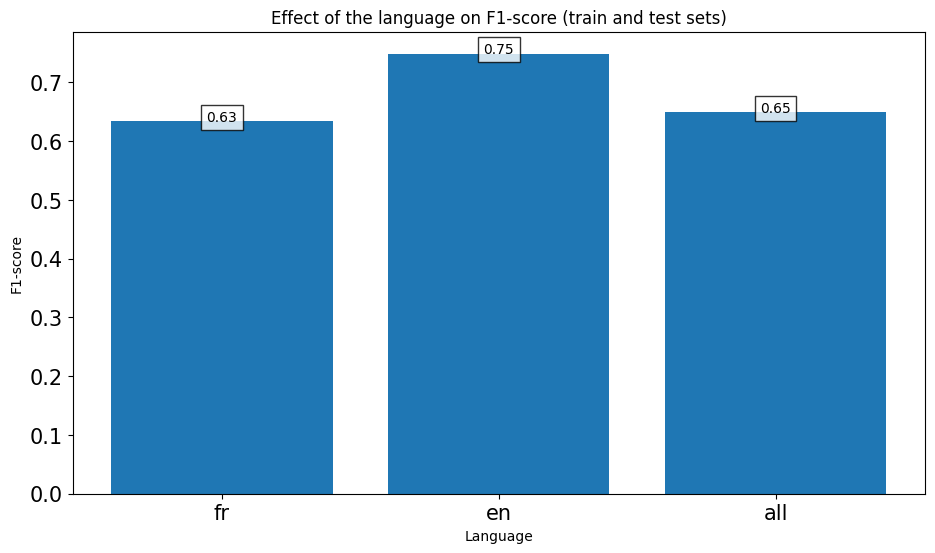

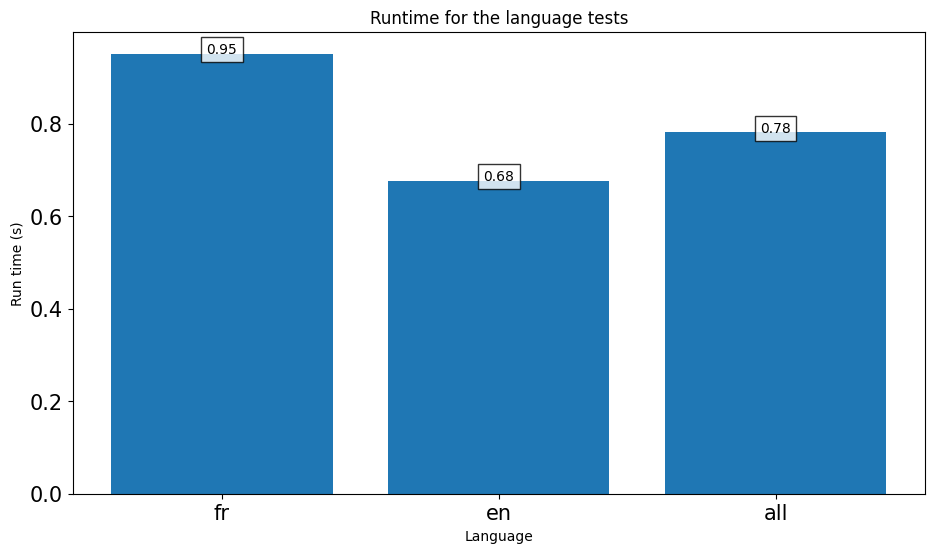

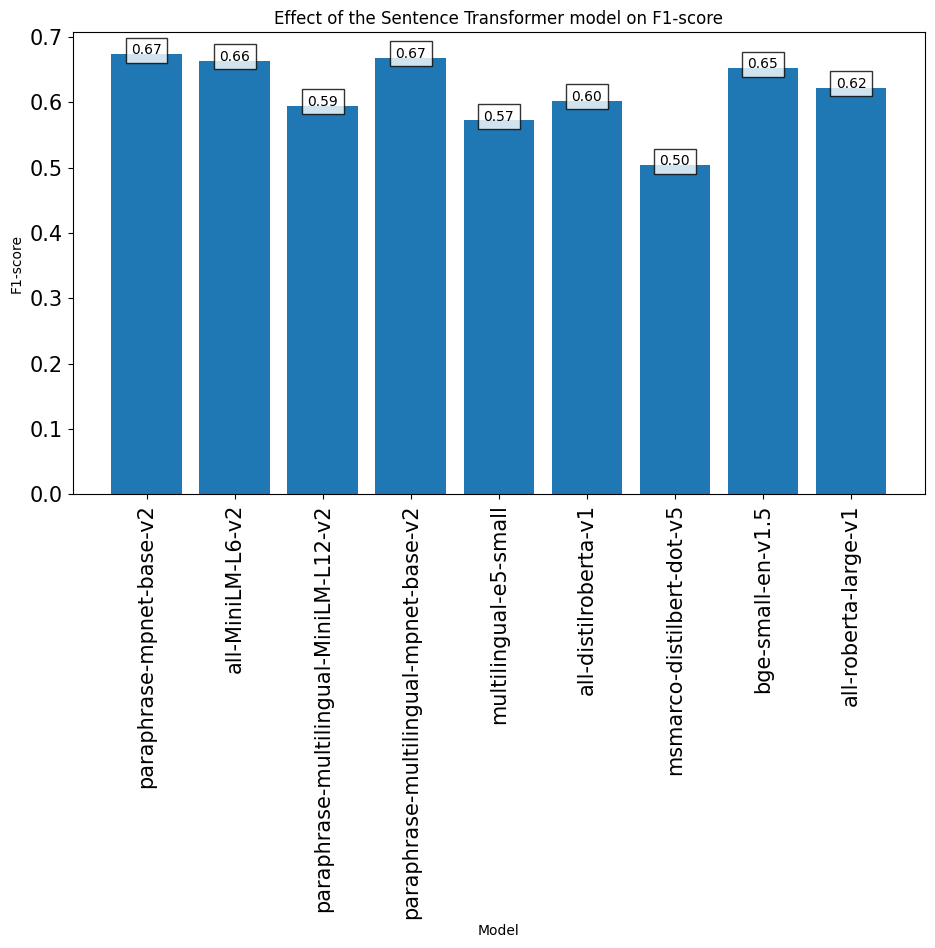

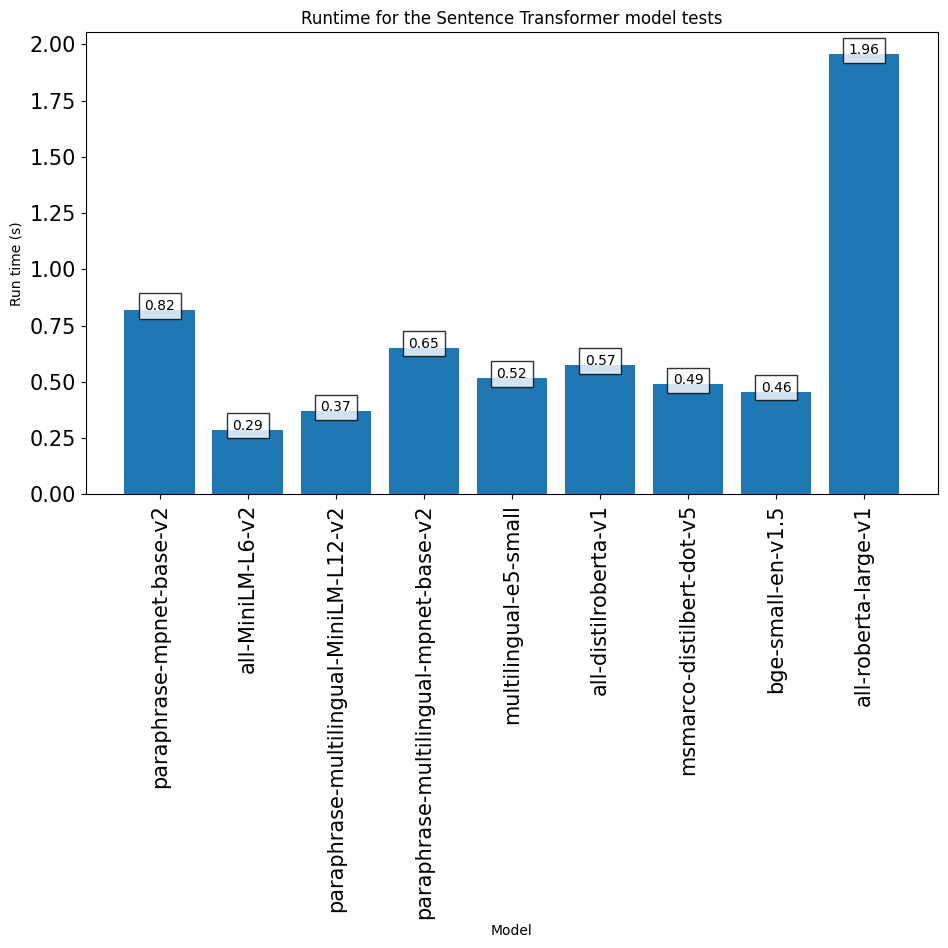

In [20]:
results, run_times = load_latest_results_data(r'../results/setfit/n_shot')
create_scatter_line_plot(results, 'Effect of the number of shots on F1-score', 'N-shot', 'F1-score')
create_bar_plot(run_times, 'Runtime for the N-shot tests', 'N-shot', 'Run time (s)')

results, run_times = load_latest_results_data(r'../results/setfit/input_length')
create_bar_plot(results, 'Effect of the length of the input on F1-score (train set only)', 'Number of words', 'F1-score')
create_bar_plot(run_times, 'Runtime for the input length tests', 'Number of words', 'Run time (s)')

results, run_times = load_latest_results_data(r'../results/setfit/distance')
create_bar_plot(results, 'Effect of the distance on F1-score', 'Distance', 'F1-score')
create_bar_plot(run_times, 'Runtime for the distance tests', 'Distance', 'Run time (s)')

results, run_times = load_latest_results_data(r'../results/setfit/language')
create_bar_plot(results, 'Effect of the language on F1-score (train and test sets)', 'Language', 'F1-score')
create_bar_plot(run_times, 'Runtime for the language tests', 'Language', 'Run time (s)')

results, run_times = load_latest_results_data(r'../results/setfit/model')
create_bar_plot(results, 'Effect of the Sentence Transformer model on F1-score', 'Model', 'F1-score', vertical_xticks=True)
create_bar_plot(run_times, 'Runtime for the Sentence Transformer model tests', 'Model', 'Run time (s)', vertical_xticks=True)

## Hyperparameter Optimization (with optuna)

In [21]:
from typing import Dict, Any, Union
from optuna import Trial

def model_init(params: Dict[str, Any]) -> SetFitModel:
    params = params or {}
    max_iter = params.get("max_iter", 100)
    solver = params.get("solver", "liblinear")
    params = {
        "head_params": {
            "max_iter": max_iter,
            "solver": solver,
        }
    }
    return SetFitModel.from_pretrained("sentence-transformers/paraphrase-multilingual-mpnet-base-v2", **params)

def hp_space(trial: Trial) -> Dict[str, Union[float, int, str]]:
    return {
        "body_learning_rate": trial.suggest_float("body_learning_rate", 1e-6, 1e-3, log=True),
        "num_epochs": trial.suggest_int("num_epochs", 1, 2),
        "batch_size": trial.suggest_categorical("batch_size", [8, 16, 32]),
        "seed": trial.suggest_int("seed", 1, 40),
        "max_iter": trial.suggest_int("max_iter", 50, 300),
        "solver": trial.suggest_categorical("solver", ["newton-cg", "lbfgs", "liblinear"]),
    }
    
new_train_set = Dataset.from_pandas(train_set, split="train")
new_train_set = sample_dataset(new_train_set, label_column="label", num_samples=8)
new_test_set = Dataset.from_pandas(test_set, split="test")

trainer = Trainer(
    train_dataset=new_train_set,
    eval_dataset=new_train_set,
    model_init=model_init,
    metric='f1',
)

best_run = trainer.hyperparameter_search(direction="maximize", hp_space=hp_space, n_trials=10)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

{'embedding_loss': 0.1883, 'learning_rate': 5.063135705176968e-06, 'epoch': 0.2}
{'train_runtime': 6.335, 'train_samples_per_second': 25.257, 'train_steps_per_second': 0.789, 'epoch': 1.0}


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

{'embedding_loss': 0.1875, 'learning_rate': 4.378416782646164e-06, 'epoch': 0.2}
{'train_runtime': 16.982, 'train_samples_per_second': 18.843, 'train_steps_per_second': 0.589, 'epoch': 2.0}


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

{'embedding_loss': 0.1875, 'learning_rate': 0.0001618441403125536, 'epoch': 0.2}
{'train_runtime': 7.921, 'train_samples_per_second': 20.199, 'train_steps_per_second': 0.631, 'epoch': 1.0}


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'embedding_loss': 0.1758, 'learning_rate': 5.784945603212164e-05, 'epoch': 0.11}
{'train_runtime': 20.303, 'train_samples_per_second': 14.185, 'train_steps_per_second': 0.887, 'epoch': 2.0}


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'embedding_loss': 0.1654, 'learning_rate': 1.1827320266143048e-05, 'epoch': 0.11}
{'train_runtime': 9.661, 'train_samples_per_second': 14.905, 'train_steps_per_second': 0.932, 'epoch': 1.0}


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

{'embedding_loss': 0.1602, 'learning_rate': 9.163175009538302e-07, 'epoch': 0.06}
{'train_runtime': 31.633, 'train_samples_per_second': 9.104, 'train_steps_per_second': 1.138, 'epoch': 2.0}


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

{'embedding_loss': 0.1922, 'learning_rate': 0.00010067576423927498, 'epoch': 0.2}
{'train_runtime': 8.039, 'train_samples_per_second': 19.903, 'train_steps_per_second': 0.622, 'epoch': 1.0}


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

{'embedding_loss': 0.188, 'learning_rate': 3.919325134012801e-05, 'epoch': 0.2}
{'train_runtime': 8.749, 'train_samples_per_second': 18.288, 'train_steps_per_second': 0.571, 'epoch': 1.0}


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

{'embedding_loss': 0.1915, 'learning_rate': 8.732786183353698e-05, 'epoch': 0.2}
{'train_runtime': 17.976, 'train_samples_per_second': 17.802, 'train_steps_per_second': 0.556, 'epoch': 2.0}


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

{'embedding_loss': 0.187, 'learning_rate': 0.00011485915004084542, 'epoch': 0.2}
{'train_runtime': 8.134, 'train_samples_per_second': 19.671, 'train_steps_per_second': 0.615, 'epoch': 1.0}


In [22]:
print(best_run)

BestRun(run_id='0', objective=1.0, hyperparameters={'body_learning_rate': 5.063135705176968e-06, 'num_epochs': 1, 'batch_size': 32, 'seed': 4, 'max_iter': 151, 'solver': 'lbfgs'}, backend=<optuna.study.study.Study object at 0x000002C6980768F0>)


In [23]:
trainer.apply_hyperparameters(best_run.hyperparameters, final_model=True)
trainer.train()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

{'embedding_loss': 0.1883, 'learning_rate': 5.063135705176968e-06, 'epoch': 0.2}
{'train_runtime': 13.307, 'train_samples_per_second': 12.024, 'train_steps_per_second': 0.376, 'epoch': 1.0}


In [24]:
trainer.evaluate()

{'f1': 1.0}